In [1]:
!pip install pennylane scikit-learn numpy matplotlib

Defaulting to user installation because normal site-packages is not writeable
  Using cached pennylane-0.42.3-py3-none-any.whl.metadata (11 kB)
  Using cached matplotlib-3.10.6-cp313-cp313-win_amd64.whl.metadata (11 kB)
  Using cached scipy-1.16.1-cp313-cp313-win_amd64.whl.metadata (60 kB)
  Using cached networkx-3.5-py3-none-any.whl.metadata (6.3 kB)
  Using cached rustworkx-0.17.1-cp39-abi3-win_amd64.whl.metadata (10 kB)
  Using cached autograd-1.8.0-py3-none-any.whl.metadata (7.5 kB)
  Using cached appdirs-1.4.4-py2.py3-none-any.whl.metadata (9.0 kB)
  Using cached autoray-0.7.2-py3-none-any.whl.metadata (5.8 kB)
  Using cached cachetools-6.2.0-py3-none-any.whl.metadata (5.4 kB)
  Using cached pennylane_lightning-0.42.0-cp313-cp313-win_amd64.whl.metadata (11 kB)
  Using cached tomlkit-0.13.3-py3-none-any.whl.metadata (2.8 kB)
  Using cached diastatic_malt-2.15.2-py3-none-any.whl.metadata (2.6 kB)
  Using cached joblib-1.5.2-py3-none-any.whl.metadata (5.6 kB)
  Using cached threadpoo

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [7]:
import numpy as np
import pandas as pd
import pennylane as qml
from sklearn.preprocessing import StandardScaler, MinMaxScaler

CSV_PATH = "concrete_cleanLOF.csv"

FEATURE_COLS = [
    "Cement",
    "BlastFurnaceSlag",
    "FlyAsh",
    "Water",
    "Superplasticizer",
    "CoarseAggregate",
    "FineAggregate",
    "Age",
]
TARGET_COL = "ConcreteCompressiveStrength"
OUTLIER_FLAG = "is_outlier"             

df = pd.read_csv(CSV_PATH)

missing = [c for c in FEATURE_COLS if c not in df.columns]
if missing:
    raise ValueError(f"Faltan columnas en el CSV: {missing}")

X = df[FEATURE_COLS].to_numpy(dtype=np.float64)
y_reg = df[TARGET_COL].to_numpy(dtype=np.float64) if TARGET_COL in df.columns else None
y_clf = df[OUTLIER_FLAG].astype(int).to_numpy() if OUTLIER_FLAG in df.columns else None

N_SAMPLES, N_FEATURES = X.shape
print(f"[INFO] Cargadas {N_SAMPLES} filas con {N_FEATURES} features.")

X = StandardScaler().fit_transform(X)
X = MinMaxScaler(feature_range=(-1.0, 1.0)).fit_transform(X)

qubits_angle     = N_FEATURES               
qubits_basis     = N_FEATURES               
qubits_amplitude = int(np.ceil(np.log2(N_FEATURES)))  

wires_angle = list(range(qubits_angle))
dev_angle   = qml.device("default.qubit", wires=wires_angle, shots=None)

@qml.qnode(dev_angle, diff_method=None)
def pl_angle_embedding(x: np.ndarray):
    qml.AngleEmbedding(features=x, wires=wires_angle, rotation="Y")
    return qml.state()

def binarize_sign(x: np.ndarray) -> np.ndarray:
    return (x > 0).astype(int)

wires_basis = list(range(qubits_basis))
dev_basis   = qml.device("default.qubit", wires=wires_basis, shots=None)

@qml.qnode(dev_basis, diff_method=None)
def pl_basis_embedding(x: np.ndarray):
    bits = binarize_sign(x) 
    qml.BasisEmbedding(bits, wires=wires_basis)
    return qml.probs(wires=wires_basis)

wires_amp = list(range(qubits_amplitude))
dev_amp   = qml.device("default.qubit", wires=wires_amp, shots=None)

@qml.qnode(dev_amp, diff_method=None)
def pl_amplitude_embedding(x: np.ndarray):
    qml.AmplitudeEmbedding(
        features=x,
        wires=wires_amp,
        pad_with=0.0,
        normalize=True, 
    )
    return qml.state()

[INFO] Cargadas 978 filas con 8 features.


=== Tiempo de *embedding* sobre TODO el dataset ===
                    Qubits  Total time (s)  Time / sample (ms)  \
Embedding                                                        
AngleEmbedding           8           0.834               0.853   
BasisEmbedding           8           0.379               0.388   
AmplitudeEmbedding       3           0.349               0.357   

                    Time / feature (µs)  
Embedding                                
AngleEmbedding                  106.617  
BasisEmbedding                   48.488  
AmplitudeEmbedding               44.612  


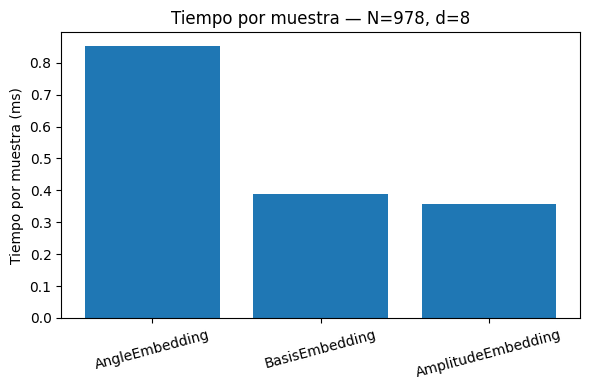

In [8]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

N = len(X)
d = X.shape[1]

def probs_from_state(psi):
    p = np.abs(psi)**2
    return p / p.sum()

def top_k_probs(p, k=8):
    idx = np.argsort(p)[-k:][::-1]
    return [(int(i), float(p[i])) for i in idx]

def bitstring_from_index(idx, width):
    return np.binary_repr(int(idx), width=width)[::-1]

qubits_info = {
    "AngleEmbedding": d,
    "BasisEmbedding": d,
    "AmplitudeEmbedding": int(np.ceil(np.log2(d))),
}

def encode_dataset_total(embedding_name, fn, returns_state=True, keep_examples_idx=(0,1,2)):
    _ = fn(X[0]) 

    t0 = time.perf_counter()
    examples = []
    for i, x in enumerate(X):
        out = fn(x)
        if i in keep_examples_idx:
            if returns_state:
                p = probs_from_state(out)
                examples.append({
                    "index": i,
                    "type": "state",
                    "top8": top_k_probs(p, k=min(8, len(p))),
                    "dim": len(out),
                })
            else:
                idx_max = int(np.argmax(out))
                width = qubits_info[embedding_name]
                examples.append({
                    "index": i,
                    "type": "probs",
                    "argmax_idx": idx_max,
                    "argmax_prob": float(out[idx_max]),
                    "bitstring": bitstring_from_index(idx_max, width=width),
                    "dim": len(out),
                })
    total_s = time.perf_counter() - t0
    return total_s, examples

angle_total_s, angle_examples = encode_dataset_total("AngleEmbedding", pl_angle_embedding, returns_state=True)
basis_total_s, basis_examples = encode_dataset_total("BasisEmbedding", pl_basis_embedding, returns_state=False)
amp_total_s,   amp_examples   = encode_dataset_total("AmplitudeEmbedding", pl_amplitude_embedding, returns_state=True)

rows = []
for name, total_s in [
    ("AngleEmbedding", angle_total_s),
    ("BasisEmbedding", basis_total_s),
    ("AmplitudeEmbedding", amp_total_s),
]:
    per_sample_s = total_s / N
    per_feature_s = per_sample_s / d
    rows.append({
        "Embedding": name,
        "Qubits": qubits_info[name],
        "Total time (s)": total_s,
        "Time / sample (ms)": per_sample_s * 1e3,
        "Time / feature (µs)": per_feature_s * 1e6,
    })

df = pd.DataFrame(rows).set_index("Embedding").sort_values("Time / sample (ms)", ascending=False)
print("=== Tiempo de *embedding* sobre TODO el dataset ===")
print(df.round(3))

plt.figure(figsize=(6,4))
plt.bar(df.index.tolist(), df["Time / sample (ms)"].values)
plt.ylabel("Tiempo por muestra (ms)")
plt.title(f"Tiempo por muestra — N={N}, d={d}")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()
